In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

C:\Users\a1996\AppData\Local\Temp/ipykernel_27812/2545383328.py:12: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)


In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibmq_mumbai"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
data_folder = "Noisy_Id_Data/"

n_qubits = 3
reps = 8
max_num_itrs = 10

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067398 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067434 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067315 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

In [4]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.9926, 0.0074], [0.0232, 0.9768]],
 'gate_qubits': [(26,)]}

In [5]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-06-15 02:37:25-04:00


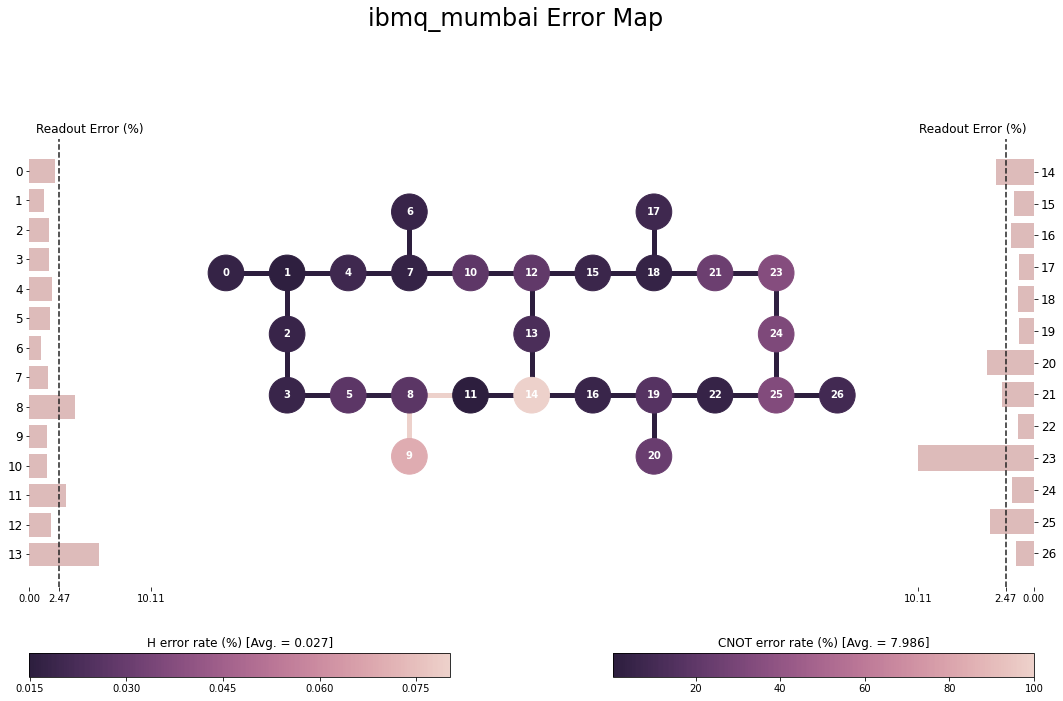

In [6]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

plot_error_map(backend, figsize=(18, 12))

In [7]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.barrier()
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

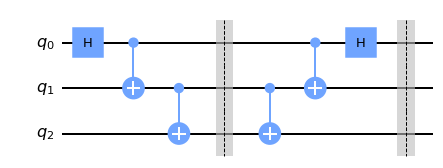

In [8]:
single_iter(n_qubits).draw("mpl")

In [10]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 101
T1: 0.00011917516179723865 sec
T2: 3.0439506411298503e-05 sec
Circuit Operation Time: 2.7445333333333333e-05 sec


## Collect Measurement Data from Real Machine

In [11]:
job_list = []
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), backend=backend).copy(name=str(i))
    job_list.append(trans_circ)
iter_job = execute(job_list,shots=8192,backend=backend)
job_monitor(iter_job)

Job Status: job has successfully run


In [12]:
print(iter_job.job_id()) # 62a989fd72bc0a0db3aa2b7a

62a989fd72bc0a0db3aa2b7a


In [13]:
real_probs = [] # measurement result
for i in range(1, max_num_itrs+1):
    iter_res = iter_job.result()
    iter_vec = KSEM.dictToVec(iter_res.get_counts(str(i)))
    real_probs.append(iter_vec)
    
# Save to numpy
np.save(data_folder+backend.properties().to_dict()['backend_name']+'_meas_vec.npy',np.array(real_probs))

In [14]:
# Load
real_probs = np.load(data_folder+backend.properties().to_dict()['backend_name']+'_meas_vec.npy')

## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [21]:
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 0
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067398 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067434 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067315 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

In [22]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)
# Obtain Measurement Error Matrix
qr = QuantumRegister(n_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
for i in range(len(meas_calibs)):
    meas_calibs[i] = transpile(meas_calibs[i],den_simu)

job_meas = den_simu.run(meas_calibs,shots=reps*8192,optimization_level=0)
cal_results = job_meas.result()
meas_fitter = CompleteMeasFitter(cal_results,state_labels,circlabel='mcal')
meas_filter = meas_fitter.filter
cal_mat= meas_filter.cal_matrix
np.save(data_folder+backend.properties().to_dict()['backend_name']+'_cal_mat.npy', cal_mat)

In [23]:
cal_mat = np.load(data_folder+backend.properties().to_dict()['backend_name']+'_cal_mat.npy')
cal_mat

array([[9.61563110e-01, 2.22778320e-02, 1.56555176e-02, 5.95092773e-04,
        2.10266113e-02, 5.64575195e-04, 2.74658203e-04, 0.00000000e+00],
       [1.77917480e-02, 9.55871582e-01, 3.35693359e-04, 1.45568848e-02,
        3.20434570e-04, 2.28118896e-02, 0.00000000e+00, 3.50952148e-04],
       [9.21630859e-03, 1.83105469e-04, 9.54788208e-01, 2.41088867e-02,
        1.52587891e-04, 1.52587891e-05, 2.10571289e-02, 4.73022461e-04],
       [2.44140625e-04, 9.53674316e-03, 1.82647705e-02, 9.49691772e-01,
        3.05175781e-05, 2.28881836e-04, 3.81469727e-04, 2.08435059e-02],
       [1.08489990e-02, 2.59399414e-04, 1.67846680e-04, 0.00000000e+00,
        9.51095581e-01, 2.34069824e-02, 1.42059326e-02, 2.59399414e-04],
       [2.13623047e-04, 1.17797852e-02, 0.00000000e+00, 1.52587891e-04,
        1.83258057e-02, 9.43786621e-01, 2.74658203e-04, 1.50604248e-02],
       [1.22070312e-04, 0.00000000e+00, 1.05438232e-02, 3.50952148e-04,
        8.89587402e-03, 3.05175781e-04, 9.46258545e-01, 2.

In [24]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [25]:
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
iter_res.get_counts()

{'000': 56227,
 '011': 767,
 '001': 4266,
 '100': 1328,
 '101': 732,
 '010': 1256,
 '111': 487,
 '110': 473}

In [26]:
np.random.seed(7)


total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    total_simu_probs.append(KSEM.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.9251115293371137
0.8578051808364678
0.7972877705550245
0.7428507717886358
0.6938611796465897
0.6497533680588906
0.6100218309278951
0.5742147109880021
0.5419280304890257
0.5128005472135531

Prob Vec
[0.92527771 0.0350647  0.01231384 0.00415039 0.01408386 0.00379944
 0.00267029 0.00263977]
[0.8923645  0.05006409 0.01631165 0.00761414 0.01678467 0.00682068
 0.00506592 0.00497437]
[0.8581543  0.0652771  0.01957703 0.01234436 0.0186615  0.01124573
 0.00784302 0.00689697]
[0.82551575 0.07946777 0.02249146 0.01670837 0.02241516 0.01448059
 0.00942993 0.00949097]
[0.79632568 0.09152222 0.02496338 0.01930237 0.02571106 0.0178833
 0.01222229 0.0120697 ]
[0.76950073 0.10301208 0.02963257 0.02360535 0.02775574 0.01870728
 0.01359558 0.01419067]
[0.74246216 0.11579895 0.03147888 0.0249939  0.03036499 0.02264404
 0.01629639 0.01596069]
[0.71795654 0.12477112 0.03625488 0.02949524 0.03199768 0.02505493
 0.01669312 0.01777649]
[0.6900177  0.137146   0.03881836 0.03257751 0.03479004 0.02711487

## Kalman Smoother

In [27]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [28]:
real_probs

array([[0.88977051, 0.04626465, 0.01672363, 0.01037598, 0.02062988,
        0.00878906, 0.0045166 , 0.00292969],
       [0.79602051, 0.11376953, 0.02697754, 0.01586914, 0.0213623 ,
        0.01245117, 0.00976562, 0.00378418],
       [0.67443848, 0.19189453, 0.04321289, 0.02539062, 0.02478027,
        0.01489258, 0.01782227, 0.00756836],
       [0.55834961, 0.26831055, 0.06091309, 0.03588867, 0.02453613,
        0.02246094, 0.01965332, 0.0098877 ],
       [0.42651367, 0.34289551, 0.0736084 , 0.04248047, 0.03649902,
        0.04077148, 0.02233887, 0.01489258],
       [0.31542969, 0.36120605, 0.09680176, 0.05114746, 0.05871582,
        0.06506348, 0.03051758, 0.02111816],
       [0.22705078, 0.36120605, 0.10705566, 0.06555176, 0.09448242,
        0.08520508, 0.03295898, 0.02648926],
       [0.17614746, 0.33410645, 0.11340332, 0.07788086, 0.13781738,
        0.08630371, 0.04016113, 0.03417969],
       [0.15344238, 0.28662109, 0.11865234, 0.09521484, 0.14880371,
        0.09594727, 0.049926

In [29]:
initial_state = np.array([0]*(real_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [85]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = real_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1+1j)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [86]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 8, 4096)

### EM and Smoother - Total

Use longest iterations

In [87]:
total_smoother_dens = []
total_smoother_purs = []

observs = real_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 

x_est_norms = []
for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape(num_dim_obs, num_dim_obs)
#     x_est = (x_est+x_est.H)/2
    final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll 913.69, Last ll 903.69
Iteration     1, New log-likelihood 9.22415e+02, Last log-likelihood 9.13688e+02, Change 8.72694e+00


Only use the estimation in the final iteration as the valid output

In [88]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     observs = real_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, x, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape(num_dim_obs, num_dim_obs)
#     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [89]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [90]:
with np.printoptions(precision=3, suppress=True):
#     for den in total_smoother_dens:
#         print(den)
    print(total_smoother_dens[8])
    print(total_simu_dens[8].data)

[[ 0.195+0.j    -0.   +0.j    -0.   +0.j    -0.   +0.j    -0.   +0.j
  -0.   +0.j    -0.   +0.j    -0.   +0.j   ]
 [-0.   -0.j     0.211+0.j     0.   +0.j    -0.   -0.j    -0.   -0.j
  -0.   -0.j    -0.   -0.j    -0.   -0.j   ]
 [-0.   -0.j     0.   -0.j     0.109+0.j     0.   -0.j     0.   -0.j
  -0.   -0.j    -0.   -0.j    -0.   -0.j   ]
 [-0.   -0.j    -0.   +0.j     0.   +0.j     0.145-0.j    -0.   +0.j
  -0.   +0.001j -0.   +0.j    -0.   +0.j   ]
 [-0.   -0.j    -0.   +0.j     0.   +0.j    -0.   -0.j     0.132-0.j
   0.   -0.001j -0.   -0.j    -0.   -0.j   ]
 [-0.   -0.j    -0.   +0.j    -0.   +0.j    -0.   -0.001j  0.   +0.001j
   0.102+0.j    -0.   -0.j    -0.   +0.j   ]
 [-0.   -0.j    -0.   +0.j    -0.   +0.j    -0.   -0.j    -0.   +0.j
  -0.   +0.j     0.055+0.j     0.   +0.001j]
 [-0.   -0.j    -0.   +0.j    -0.   +0.j    -0.   -0.j    -0.   +0.j
  -0.   -0.j     0.   -0.001j  0.051+0.j   ]]
[[ 0.718+0.j  0.056+0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
   0.   +0.j  0.

In [91]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.784900990005135
0.6028088371478885
0.4473491568732635
0.3571343829647244
0.3519906049587469
0.39079628554723495
0.3435886132374573
0.22431936701836186
0.14878612774975564
0.15233611041196515


## Check the fidelity between estimated state and the real state in the simulator

In [92]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

def dist(p,q):
    return np.abs(p-q).sum()*0.5

Iteration 1 KS Dist: 0.04692417012408183 Simu Dist: 0.0717828280737778
Iteration 2 KS Dist: 0.07681412371152338 Simu Dist: 0.13027557169273915
Iteration 3 KS Dist: 0.11636203130678743 Simu Dist: 0.21611294666728093
Iteration 4 KS Dist: 0.09419572294413384 Simu Dist: 0.29943860902575137
Iteration 5 KS Dist: 0.09814384271278262 Simu Dist: 0.4002073006851679
Iteration 6 KS Dist: 0.1861029874987893 Simu Dist: 0.4818296939562735
Iteration 7 KS Dist: 0.3021601281038539 Simu Dist: 0.542267290355781
Iteration 8 KS Dist: 0.29236785548206784 Simu Dist: 0.5666688659052204
Iteration 9 KS Dist: 0.10327568282092368 Simu Dist: 0.5642354473579307
Iteration 10 KS Dist: 0.26950993894677033 Simu Dist: 0.5505198731806931


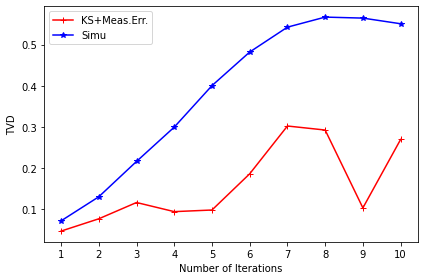

In [93]:
diff_fed_all= []
diff_fed_simu= []
for i in range(max_num_itrs):
    fed_difference_simu =  dist(real_probs[i].data, total_simu_dens[i].probabilities())
    KS_vec = np.array(total_smoother_dens[i].diagonal()).flatten().real
    noisy_KS_vec = cal_mat.dot(KS_vec)
    fed_difference_all =  dist(real_probs[i].data, noisy_KS_vec)
    diff_fed_all.append(fed_difference_all)
    diff_fed_simu.append(fed_difference_simu)
    print("Iteration",i+1, "KS Dist:", fed_difference_all, "Simu Dist:", fed_difference_simu)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS+Meas.Err.')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_simu)[iter_range], '*-', color='blue', label='Simu')
plt.xlabel("Number of Iterations")
plt.ylabel("TVD")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig(data_folder+backend.properties().to_dict()['backend_name']+"_diff_dist.svg")
plt.show()

In [75]:
np.sum(diff_fed_all)

1.5858564836517142